In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"solanki123","key":"0c83f1e041f3fea95b621e6cfdd0d304"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json
 

In [ ]:
 ! kaggle datasets list

ref                                                       title                                                size  lastUpdated          downloadCount  
--------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                           7MB  2021-02-12 07:51:24            736  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020                    16KB  2021-01-30 14:20:45            881  
aagghh/crypto-telegram-groups                             Crypto telegram groups                              297MB  2021-02-02 09:58:25            101  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                               1MB  2021-01-29 13:53:50            143  
timoboz/superbowl-history-1967-2020                       Superbowl History 

In [ ]:
! kaggle competitions download -c 'Malaria Cell Images Dataset'

404 - Not Found


In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p Dataset

 99% 666M/675M [00:05<00:00, 131MB/s]
100% 675M/675M [00:06<00:00, 118MB/s]


In [ ]:
!unzip /content/Dataset/cell-images-for-detecting-malaria.zip -d /content/drive/MyDrive/malaria_detection

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: /content/drive/MyDrive/malaria_detection/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating

In [1]:
import os
import glob

base_dir = os.path.join('/content/drive/MyDrive/malaria_detection/cell_images/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

balanced dataset with 13,779 malaria and 13,779 non-malaria (uninfected) cell images.

Now will build the dataframe, which will be used to build the dataset

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/MyDrive/malaria_detection/cell_...,malaria
1,/content/drive/MyDrive/malaria_detection/cell_...,malaria
2,/content/drive/MyDrive/malaria_detection/cell_...,healthy
3,/content/drive/MyDrive/malaria_detection/cell_...,healthy
4,/content/drive/MyDrive/malaria_detection/cell_...,healthy


We need training data, but we also need to test the model's performance on unseen data. We will use a 60:10:30 split for train, validation, and test datasets, respectively. We will leverage the train and validation datasets during training and check the performance of the model on the test dataset.


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values,
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


The images will not be of equal dimensions because blood smears and cell images vary based on the human, the test method, and the orientation of the photo. 

We will check summary statistics of our training dataset to determine the optimal image dimension

In [4]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
 
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel,
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0))
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_4: working on img num: 5000
ThreadPoolExecutor-0_6: working on img num: 10000
ThreadPoolExecutor-0_4: working on img num: 15000
ThreadPoolExecutor-0_3: working on img num: 17360
Min Dimensions: [40 46  3]
Avg Dimensions: [132.94176603 132.49801279   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 364   3]


We apply parallel processing to speed up the image-read operations and, based on the summary statistics, we will resize each image to 125x125 pixels. 
Now we will load up all of our images and resize them to these fixed dimensions.



In [5]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  


Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_2: working on img num: 5000
ThreadPoolExecutor-1_9: working on img num: 10000
ThreadPoolExecutor-1_8: working on img num: 15000
ThreadPoolExecutor-1_4: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_8: working on img num: 0
ThreadPoolExecutor-1_5: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_6: working on img num: 0
ThreadPoolExecutor-1_2: working on img num: 5000
ThreadPoolExecutor-1_2: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

viewing some sample cell images to get an idea of how our data looks.

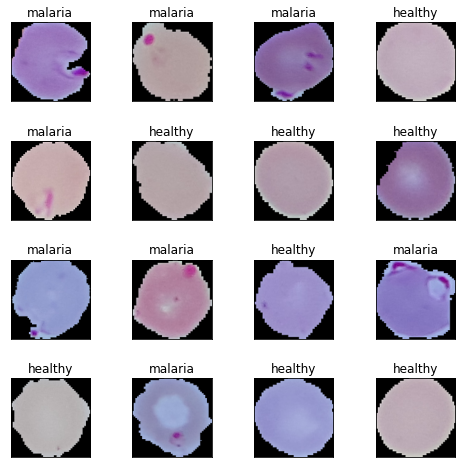

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

We will make our deep learning models try to learn these patterns during model training.

Before can we start training our models, we must set up some basic configuration settings.

In [6]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])


['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


We fix our image dimensions, batch size, and epochs and encode our categorical class labels. 

In [7]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard
tf.random.set_seed(42)
tf.__version__

'2.4.1'

# **Deep learning model training**

In the model training phase, we will build three deep learning models, train them with our training data, and compare their performance using the validation data. We will then save these models and use them later in the model evaluation phase.

**Model 1: CNN from scratch**


Our first malaria detection model will build and train a basic CNN from scratch. First, let's define our model architecture.



In [9]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

our CNN model has three convolution and pooling layers, followed by two dense layers, and dropouts for regularization. Let's train our model.



In [10]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 18s 37ms/step - loss: 0.6045 - accuracy: 0.6452 - val_loss: 0.2000 - val_accuracy: 0.9362
Epoch 2/25
272/272 [==============================] - 9s 34ms/step - loss: 0.1728 - accuracy: 0.9412 - val_loss: 0.1494 - val_accuracy: 0.9518
Epoch 3/25
272/272 [==============================] - 9s 34ms/step - loss: 0.1437 - accuracy: 0.9557 - val_loss: 0.1597 - val_accuracy: 0.9476
Epoch 4/25
272/272 [==============================] - 9s 35ms/step - loss: 0.1192 - accuracy: 0.9601 - val_loss: 0.1563 - val_accuracy: 0.9508
Epoch 5/25
272/272 [==============================] - 9s 35ms/step - loss: 0.1131 - accuracy: 0.9610 - val_loss: 0.1611 - val_accuracy: 0.9497
Epoch 6/25
272/272 [==============================] - 9s 35ms/step - loss: 0.0892 - accuracy: 0.9699 - val_loss: 0.1755 - val_accuracy: 0.9544
Epoch 7/25
272/272 [==============================] - 9s 35ms/step - loss: 0.0729 - accuracy: 0.9747 - val_loss: 0.1640 - val_accuracy: 0.950

 plotting the training and validation accuracy and loss curves.



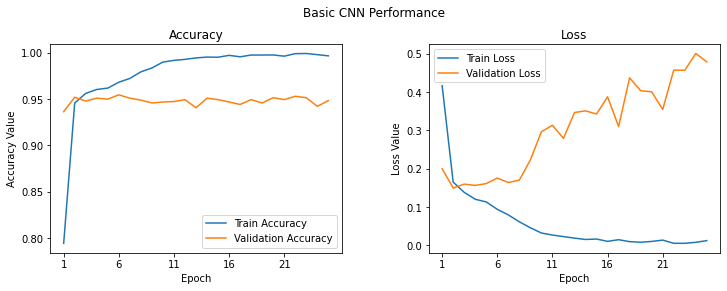

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We can see after the second
 epoch that things don't seem to improve a whole lot overall. 

This model is saved for future evaluation.



In [12]:
model.save('basic_cnn.h5')

#Deep transfer learning


We will apply the two most popular strategies for deep transfer learning.




1.   Pre-trained model as a feature extractor
2.  Pre-trained model with fine-tuning




###Model 2: Pre-trained model as a feature extractor


Use TensorFlow to load up the VGG-19 model and freeze the convolution blocks so we can use them as an image feature extractor. 

Use our own dense layers at the end to perform the classification task.

In [13]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet',
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
   
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
____________________________________________________________

we will be using the frozen layers of the VGG-19 model as feature extractors only.

In [14]:
#code to verify how many layers in our model are indeed trainable and how many total layers are present in our network.

print("Total Layers:", len(model.layers))
print("Total trainable layers:",
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


## Train the model

In [15]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 33s 114ms/step - loss: 0.4930 - accuracy: 0.7478 - val_loss: 0.2824 - val_accuracy: 0.8875
Epoch 2/25
272/272 [==============================] - 30s 111ms/step - loss: 0.3031 - accuracy: 0.8715 - val_loss: 0.2421 - val_accuracy: 0.8968
Epoch 3/25
272/272 [==============================] - 29s 107ms/step - loss: 0.2599 - accuracy: 0.8957 - val_loss: 0.2210 - val_accuracy: 0.9129
Epoch 4/25
272/272 [==============================] - 30s 109ms/step - loss: 0.2367 - accuracy: 0.9033 - val_loss: 0.2702 - val_accuracy: 0.8808
Epoch 5/25
272/272 [==============================] - 30s 109ms/step - loss: 0.2215 - accuracy: 0.9176 - val_loss: 0.3600 - val_accuracy: 0.8631
Epoch 6/25
272/272 [==============================] - 29s 108ms/step - loss: 0.2042 - accuracy: 0.9242 - val_loss: 0.1986 - val_accuracy: 0.9202
Epoch 7/25
272/272 [==============================] - 30s 109ms/step - loss: 0.1972 - accuracy: 0.9209 - val_loss: 0.2155 - val_ac

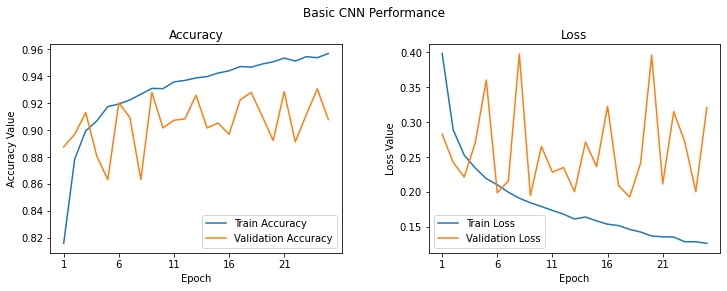

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
model.save('vgg_frozen.h5')

# Build Image Augmentors

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


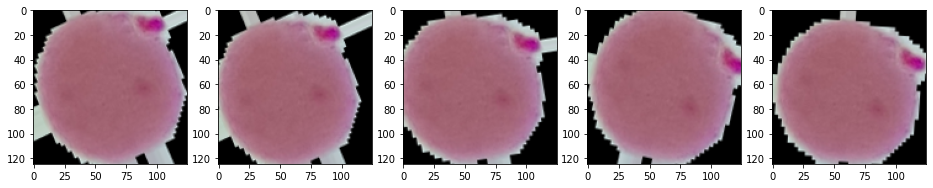

In [19]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [20]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

# Transfer Learning

## Model 3: Fine-tuned Pre-trained CNN with Image Augmentation


### Building Model Architecture

In [21]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


### training model

In [22]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
271/271 [==============================] - 75s 272ms/step - loss: 0.3457 - accuracy: 0.8389 - val_loss: 0.1564 - val_accuracy: 0.9438
Epoch 2/25
271/271 [==============================] - 73s 270ms/step - loss: 0.1518 - accuracy: 0.9507 - val_loss: 0.1429 - val_accuracy: 0.9521
Epoch 3/25
271/271 [==============================] - 73s 270ms/step - loss: 0.1276 - accuracy: 0.9553 - val_loss: 0.1200 - val_accuracy: 0.9594
Epoch 4/25
271/271 [==============================] - 73s 270ms/step - loss: 0.1164 - accuracy: 0.9610 - val_loss: 0.1274 - val_accuracy: 0.9557
Epoch 5/25
271/271 [==============================] - 73s 271ms/step - loss: 0.1106 - accuracy: 0.9617 - val_loss: 0.1199 - val_accuracy: 0.9557
Epoch 6/25
271/271 [==============================] - 73s 269ms/step - loss: 0.1097 - accuracy: 0.9616 - val_loss: 0.1196 - val_accuracy: 0.9557
Epoch 7/25
271/271 [==============================] - 73s 270ms/step - loss: 0.1058 - accuracy: 0.9644 - val_loss: 0.1400 - val_ac

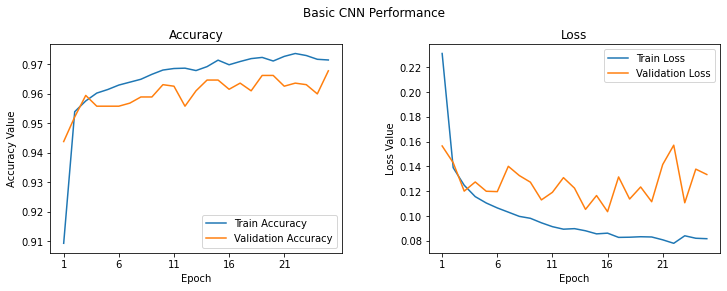

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [24]:
model.save('vgg_finetuned.h5')

###. Model Performance Evaluation

In [10]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [11]:
! ls -l --block-size=MB | grep .h5

-rw-r--r-- 1 root root 182MB Feb 18 13:45 basic_cnn.h5
-rw-r--r-- 1 root root 173MB Feb 18 14:29 vgg_finetuned.h5
-rw-r--r-- 1 root root 102MB Feb 18 13:57 vgg_frozen.h5


In [12]:
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [ ]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])